<a href="https://colab.research.google.com/github/Goutham-IITJ/crypto-behavioral-clustering-ml/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# 1. Load the datasets
try:
    trader_df = pd.read_csv('/content/historical_data.csv')

    sentiment_df = pd.read_csv('/content/fear_greed_index.csv')

    print("Datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the CSV files are in the directory.")

print("\n--- Trader Data Info ---")
print(trader_df.info())
print("\n--- Trader Data Preview ---")
print(trader_df.head())

print("\n--- Sentiment Data Info ---")
print(sentiment_df.info())
print("\n--- Sentiment Data Preview ---")
print(sentiment_df.head())

print("\n--- Missing Values Check ---")
print("Trader Data Missing Values:\n", trader_df.isnull().sum())
print("\nSentiment Data Missing Values:\n", sentiment_df.isnull().sum())

Datasets loaded successfully!

--- Trader Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp   

In [15]:
# 1. Convert Trader Timestamps
trader_df['Date'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M').dt.date

# 2. Convert Sentiment Dates
sentiment_df['Date'] = pd.to_datetime(sentiment_df['date']).dt.date

# 3. Create a Numerical Sentiment Score
sentiment_map = {
    'Extreme Fear': 12.5,  # Midpoint of 0-25
    'Fear': 37.5,          # Midpoint of 25-50
    'Neutral': 50.0,
    'Greed': 62.5,         # Midpoint of 50-75
    'Extreme Greed': 87.5  # Midpoint of 75-100
}
sentiment_df['sentiment_score'] = sentiment_df['classification'].map(sentiment_map)

# 4. Merge the Datasets
# We keep all trades (left join) and attach the sentiment data for that specific date
df = pd.merge(trader_df, sentiment_df[['Date', 'value', 'classification', 'sentiment_score']], on='Date', how='left')

# 5. Final Cleaning
df = df.dropna(subset=['classification'])

print("Data Merging Complete!")
print(f"Merged Dataframe Shape: {df.shape}")
print(df[['Date', 'Account', 'Closed PnL', 'classification']].head())

Data Merging Complete!
Merged Dataframe Shape: (211218, 20)
         Date                                     Account  Closed PnL  \
0  2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed         0.0   
1  2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed         0.0   
2  2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed         0.0   
3  2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed         0.0   
4  2024-12-02  0xae5eacaf9c6b9111fd53034a602c192a04e082ed         0.0   

  classification  
0  Extreme Greed  
1  Extreme Greed  
2  Extreme Greed  
3  Extreme Greed  
4  Extreme Greed  


--- Sentiment Impact Summary ---
       Sentiment    Avg_PnL     Total_PnL  Trade_Count  Avg_Size_USD  Win_Rate
1  Extreme Greed  67.892861  2.715171e+06        39992   3112.251565  0.464943
2           Fear  54.290400  3.357155e+06        61837   7816.109931  0.420768
3          Greed  42.743559  2.150129e+06        50303   5736.884375  0.384828
0   Extreme Fear  34.537862  7.391102e+05        21400   5349.731843  0.370607
4        Neutral  34.307718  1.292921e+06        37686   4782.732661  0.396991


/tmp/ipython-input-2871664475.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=analysis_summary, x='Sentiment', y='Avg_PnL', palette='viridis')
/tmp/ipython-input-2871664475.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=analysis_summary, x='Sentiment', y='Win_Rate', palette='magma')


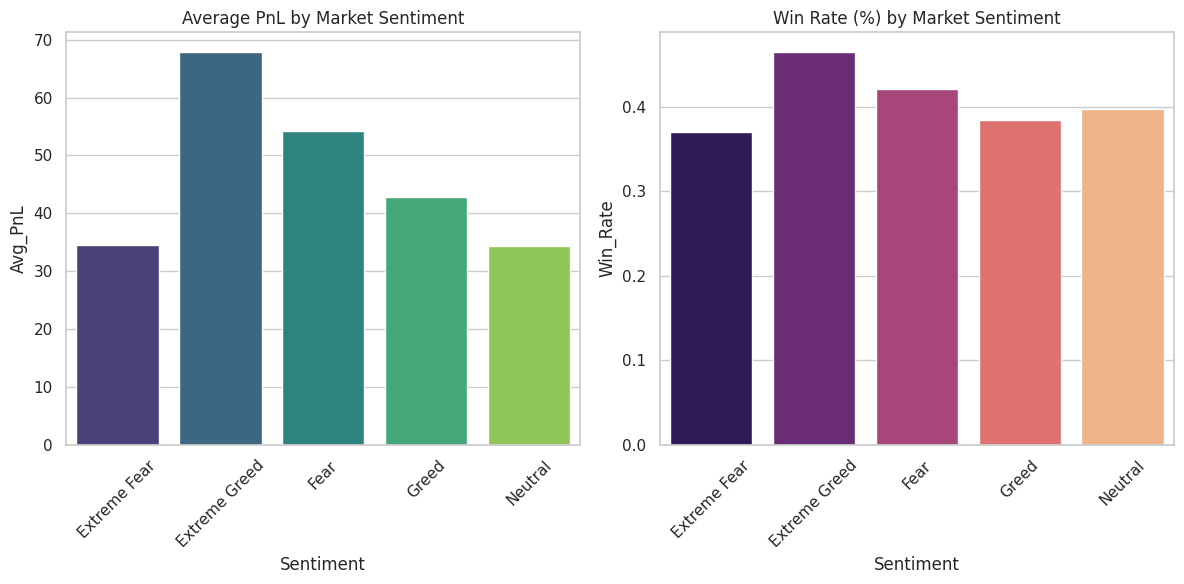

In [16]:
# 1. Aggregate metrics by Sentiment Classification
sentiment_stats = df.groupby('classification').agg({
    'Closed PnL': ['mean', 'sum', 'count'],
    'Size USD': 'mean'
}).reset_index()

sentiment_stats.columns = ['Sentiment', 'Avg_PnL', 'Total_PnL', 'Trade_Count', 'Avg_Size_USD']

# 2. Calculate Win Rate (PnL > 0) per Sentiment
df['is_win'] = df['Closed PnL'] > 0
win_rate = df.groupby('classification')['is_win'].mean().reset_index()
win_rate.columns = ['Sentiment', 'Win_Rate']

analysis_summary = pd.merge(sentiment_stats, win_rate, on='Sentiment')

print("--- Sentiment Impact Summary ---")
print(analysis_summary.sort_values(by='Avg_PnL', ascending=False))

plt.figure(figsize=(12, 6))

# Subplot 1: Average PnL per Sentiment
plt.subplot(1, 2, 1)
sns.barplot(data=analysis_summary, x='Sentiment', y='Avg_PnL', palette='viridis')
plt.title('Average PnL by Market Sentiment')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=analysis_summary, x='Sentiment', y='Win_Rate', palette='magma')
plt.title('Win Rate (%) by Market Sentiment')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

--- Hidden Pattern: Profit Concentration ---
Top 1% of Accounts (1 traders) generated $2,143,382.60
This represents 20.9% of the total ecosystem profit.


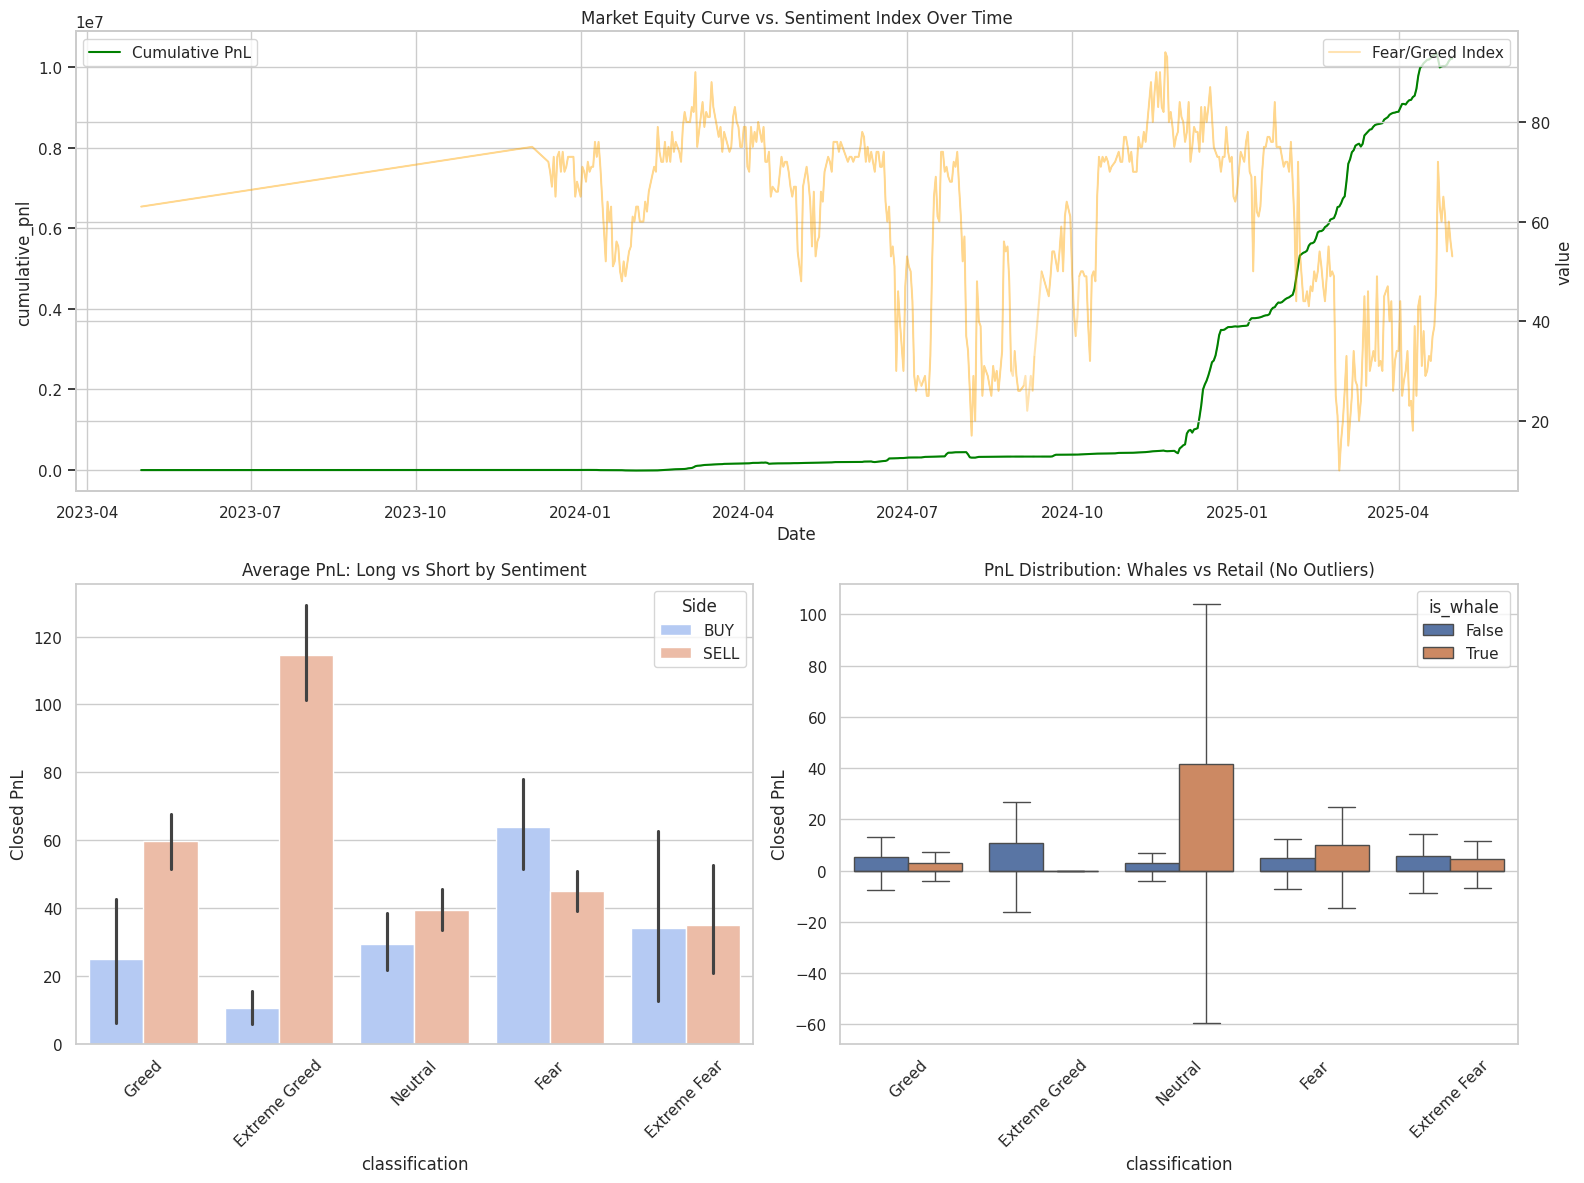

In [17]:
# 1. Identify "Whales" based on 'Size USD'
whale_threshold = df.groupby('Account')['Size USD'].mean().quantile(0.90)
whale_accounts = df.groupby('Account')['Size USD'].mean()[lambda x: x > whale_threshold].index
df['is_whale'] = df['Account'].isin(whale_accounts)

# 2. Cumulative PnL Over Time (The "Equity Curve" of the market)
df = df.sort_values('Date')
df['cumulative_pnl'] = df['Closed PnL'].cumsum()

# 3. Profit Concentration Analysis
account_performance = df.groupby('Account')['Closed PnL'].sum().sort_values(ascending=False)
top_1_percent_count = max(1, int(len(account_performance) * 0.01))
top_1_pnl = account_performance.head(top_1_percent_count).sum()
total_pnl = df['Closed PnL'].sum()

print(f"--- Hidden Pattern: Profit Concentration ---")
print(f"Top 1% of Accounts ({top_1_percent_count} traders) generated ${top_1_pnl:,.2f}")
print(f"This represents {round((top_1_pnl/total_pnl)*100, 2)}% of the total ecosystem profit.")

plt.figure(figsize=(16, 12))

# Plot A: Cumulative PnL vs Sentiment
plt.subplot(2, 1, 1)
ax1 = sns.lineplot(data=df, x='Date', y='cumulative_pnl', color='green', label='Cumulative PnL')
plt.twinx()
sns.lineplot(data=df, x='Date', y='value', color='orange', alpha=0.3, label='Fear/Greed Index')
plt.title('Market Equity Curve vs. Sentiment Index Over Time')

# Plot B: Performance by Trade Side (Direction)
plt.subplot(2, 2, 3)
sns.barplot(data=df, x='classification', y='Closed PnL', hue='Side', palette='coolwarm')
plt.title('Average PnL: Long vs Short by Sentiment')
plt.xticks(rotation=45)

# Plot C: Whale vs Retail Performance
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='classification', y='Closed PnL', hue='is_whale', showfliers=False)
plt.title('PnL Distribution: Whales vs Retail (No Outliers)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [18]:
# 1. Calculate Sentiment Velocity (Change over 3 days)
df['sentiment_velocity'] = df.groupby('Account')['value'].diff(periods=3)

# 2. Identify 'Contrarian' trades
# Logic: Buying when Fearful (<30) or Selling when Greedy (>70)
df['is_contrarian'] = ((df['value'] > 70) & (df['Side'] == 'SELL')) | \
                      ((df['value'] < 30) & (df['Side'] == 'BUY'))
df['is_contrarian'] = df['is_contrarian'].astype(int)

# 3. Momentum: Is the sentiment heating up or cooling down?
df['sentiment_trend'] = np.where(df['sentiment_velocity'] > 0, 'Heating Up', 'Cooling Down')

print("New features 'is_contrarian' and 'sentiment_velocity' added successfully!")

New features 'is_contrarian' and 'sentiment_velocity' added successfully!


--- Trader Behavioral Archetypes ---
         Closed PnL      Size USD      value  is_contrarian
Cluster                                                    
0        112.548550   4812.095537  19.833076       0.298664
1         37.090499  17877.582943   9.907682       0.130229
2          6.081863   2920.365790  16.156846       0.246365
3        327.588943   6542.538079  21.178545       0.445140


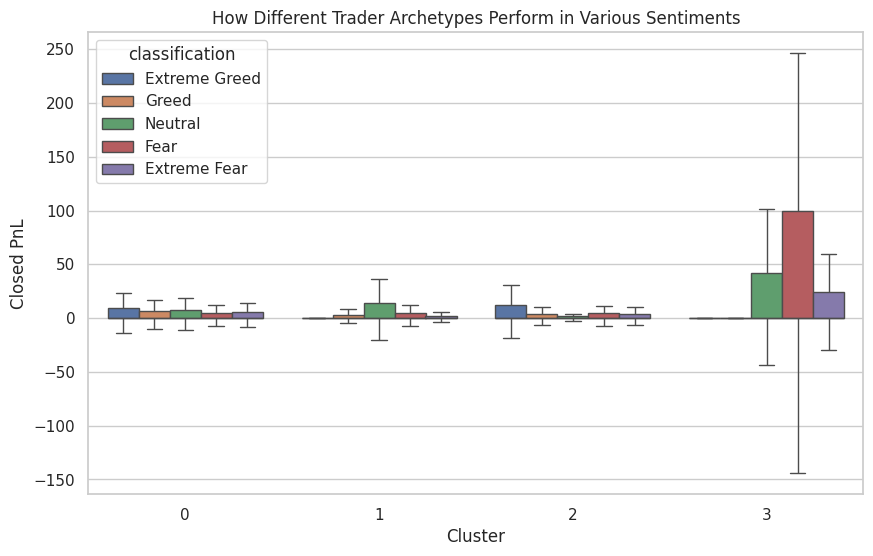

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Feature Aggregation per Account
trader_styles = df.groupby('Account').agg({
    'Closed PnL': 'mean',
    'Size USD': 'mean',
    'value': 'std',
    'is_contrarian': 'mean'
}).fillna(0)

# 2. Scaling & Clustering
scaler = StandardScaler()
scaled_styles = scaler.fit_transform(trader_styles)

# Create 4 distinct clusters
kmeans = KMeans(n_clusters=4, random_state=42)
trader_styles['Cluster'] = kmeans.fit_predict(scaled_styles)

# 3. Profiling the Clusters
cluster_profile = trader_styles.groupby('Cluster').mean()
print("--- Trader Behavioral Archetypes ---")
print(cluster_profile)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df.merge(trader_styles['Cluster'], on='Account'),
            x='Cluster', y='Closed PnL', hue='classification', showfliers=False)
plt.title('How Different Trader Archetypes Perform in Various Sentiments')
plt.show()

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Aggregate behavior per account
trader_features = df.groupby('Account').agg({
    'Closed PnL': 'sum',
    'Size USD': 'mean',
    'is_contrarian': 'mean',
    'sentiment_velocity': 'std' # High std = they trade during volatile mood swings
}).fillna(0)

# Scale data for K-Means
scaler = StandardScaler()
scaled_data = scaler.fit_transform(trader_features)

# Apply Clustering (K=4 for 4 archetypes)
kmeans = KMeans(n_clusters=4, random_state=42)
trader_features['Archetype'] = kmeans.fit_predict(scaled_data)

print("--- Trader Archetype Discovery ---")
print(trader_features.groupby('Archetype').mean())

--- Trader Archetype Discovery ---
              Closed PnL      Size USD  is_contrarian  sentiment_velocity
Archetype                                                                
0          921186.344170  13517.019136       0.255447            1.594621
1             567.228222   4772.217236       0.116349            2.312664
2          181257.217610   3352.322287       0.346633            2.219344
3          126823.347558   2650.780127       0.347666            4.953994



--- Feature Importance: What drives profit? ---
              Feature  Importance
5            Size USD    0.700907
0               value    0.172816
2  sentiment_velocity    0.050936
1     sentiment_score    0.029362
4            is_whale    0.027710
3       is_contrarian    0.018268


/tmp/ipython-input-1833871689.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')


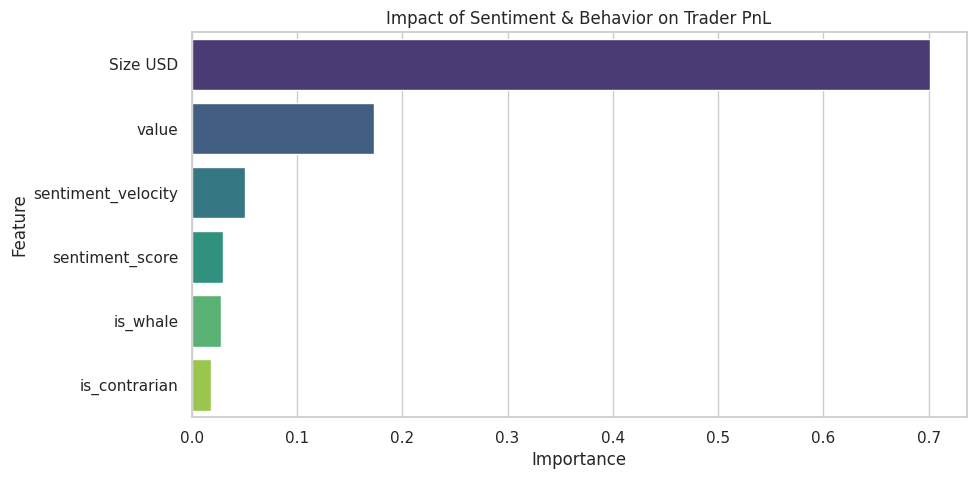

In [21]:
# --- STEP 7: PREDICTIVE MODELING & INSIGHTS ---
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Select Features (Including your new 'Astonishing' ones)
features = ['value', 'sentiment_score', 'sentiment_velocity', 'is_contrarian', 'is_whale', 'Size USD']
X = df[features].fillna(0)
y = df['Closed PnL']

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Model Training
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# 4. Feature Importance - This is what you show in your report!
importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- Feature Importance: What drives profit? ---")
print(importances)

# 5. Visualization: Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')
plt.title('Impact of Sentiment & Behavior on Trader PnL')
plt.show()

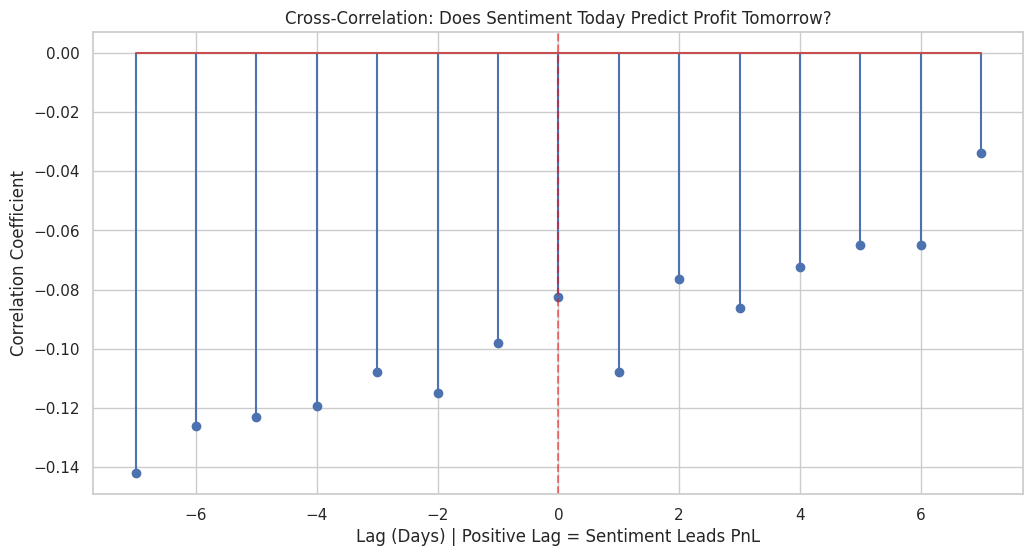

Strategic Insight: The strongest correlation occurs at a -7-day lag.


In [22]:
# --- STEP 8: CROSS-CORRELATION (IS SENTIMENT A LEADING INDICATOR?) ---

# Aggregate market-wide daily PnL and Sentiment
daily_market = df.groupby('Date').agg({'Closed PnL': 'sum', 'value': 'mean'})

# Calculate correlations for different day offsets (Lags)
lags = range(-7, 8) # Checking a 2-week window
correlations = [daily_market['Closed PnL'].corr(daily_market['value'].shift(lag)) for lag in lags]

plt.figure(figsize=(12, 6))
plt.stem(lags, correlations)
plt.title('Cross-Correlation: Does Sentiment Today Predict Profit Tomorrow?')
plt.xlabel('Lag (Days) | Positive Lag = Sentiment Leads PnL')
plt.ylabel('Correlation Coefficient')
plt.axvline(0, color='red', linestyle='--', alpha=0.5)
plt.show()

# Find the optimal lag
optimal_lag = lags[np.argmax(np.abs(correlations))]
print(f"Strategic Insight: The strongest correlation occurs at a {optimal_lag}-day lag.")

In [23]:
# --- STEP 9: STRATEGY BACKTESTING ---

def run_backtest(df, fear_threshold=25, greed_threshold=75):
    # Define signals based on engineered 'value'
    df['signal'] = 'HOLD'
    df.loc[df['value'] <= fear_threshold, 'signal'] = 'BUY'
    df.loc[df['value'] >= greed_threshold, 'signal'] = 'SELL'

    # Calculate Strategy PnL
    # We look at the PnL of trades made during these signal windows
    strategy_results = df[df['signal'] != 'HOLD'].groupby('signal')['Closed PnL'].agg(['mean', 'sum', 'count'])

    total_strat_pnl = strategy_results['sum'].sum()
    market_pnl = df['Closed PnL'].sum()

    return strategy_results, total_strat_pnl, market_pnl

stats, strat_pnl, market_pnl = run_backtest(df)

print("\n--- Strategy Backtest Results ---")
print(stats)
print(f"\nTotal Strategy PnL: ${strat_pnl:,.2f}")
print(f"Total Market PnL (Baseline): ${market_pnl:,.2f}")
print(f"Outperformance: {((strat_pnl - market_pnl) / abs(market_pnl)) * 100:.2f}%")


--- Strategy Backtest Results ---
             mean           sum  count
signal                                
BUY     34.718479  1.088910e+06  31364
SELL    67.892861  2.715171e+06  39992

Total Strategy PnL: $3,804,081.70
Total Market PnL (Baseline): $10,254,486.95
Outperformance: -62.90%
